In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import sys
import pandas as pd
import geopandas as gpd
import xarray as xr
import io, requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import glob
import datetime
from string import ascii_lowercase as alc

import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from pyEDM import *

from libs.vars import *

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [2]:
time_slice = slice('1963-10-01','2019-09-01')
pub_dir = '/Users/hkim139/Documents/research/03.manuscripts/2024/swe_causal_manuscript/figs_erl/'

In [3]:
# # ENSO nino34
nino34 = xr.open_dataset('./data/enso/nino34.nc')

In [4]:
pdo = xr.open_dataset('./data/PDO/pdo.timeseries.ersstv5.nc')
# new_slice = slice('1945-10-01','2019-09-01')
pdo = pdo.sel(time=time_slice)
# pdo_season = pdo.resample(time='QS-DEC').mean(dim='time')

In [5]:
sst_anoms = xr.open_dataset('./data/SST_anoms.nc')
swe_anoms = xr.open_dataset('./data/SWE_anoms.nc')

swe_by_eco_files = glob.glob('./data/snow_by_eco/*.nc')

In [6]:
fs = np.sort(glob.glob('./data/snow_by_eco/*.nc'))

In [7]:
for i in range(15):
    print(i, swe_by_eco_files[i])

0 ./data/snow_by_eco/snow_Klamath_Mountains.nc
1 ./data/snow_by_eco/snow_Middle_Rockies.nc
2 ./data/snow_by_eco/snow_Central_Basin_and_Range.nc
3 ./data/snow_by_eco/snow_Blue_Mountains.nc
4 ./data/snow_by_eco/snow_Canadian_Rockies.nc
5 ./data/snow_by_eco/snow_Eastern_Cascades_Slopes_and_Foothills.nc
6 ./data/snow_by_eco/snow_Wasatch_and_Uinta_Mountains.nc
7 ./data/snow_by_eco/snow_Sierra_Nevada.nc
8 ./data/snow_by_eco/snow_North_Cascades.nc
9 ./data/snow_by_eco/snow_Northern_Basin_and_Range.nc
10 ./data/snow_by_eco/snow_Columbia_Mountains_Northern_Rockies.nc
11 ./data/snow_by_eco/snow_Arizona_New_Mexico_Mountains.nc
12 ./data/snow_by_eco/snow_Southern_Rockies.nc
13 ./data/snow_by_eco/snow_Idaho_Batholith.nc
14 ./data/snow_by_eco/snow_Cascades.nc


In [8]:
# get Gulf of Alaska SSTs
goa_sst = sst_anoms.sel(lat=slice(50,40), lon=slice(220,230))
sst = goa_sst.mean(dim=['lat','lon'])

In [9]:
def CCMsetup(i, col):
    swe_anoms_by_eco = xr.open_dataset(swe_by_eco_files[i])
    swe_anoms_ts = swe_anoms_by_eco.mean(dim='sites').dropna(dim='time')
    
    # generate predicted SWE from SST
    swe = swe_anoms_ts.to_dataframe()
    #sst = goa_sst.mean(dim=['lat','lon']).to_dataframe()
    col = col.to_dataframe()
    #swe_by_eco_files[i]

    df = swe.join(col)
    df = df.dropna()
    df = df.reset_index()
    # df = df.drop(['lat', 'lon'], axis=1)
    
    df['time'] = df['time'].map(lambda x: x.isoformat())
    return(df)

In [10]:
df = CCMsetup(-1, nino34)

In [11]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

2


In [12]:
maxN = L - (E+1)
df = df[['time', 'ANOM','swe_level2']]

# look at orange line!
ccm_Ca_enso_lag1 = CCM(dataFrame=df,
                    E = int(E),
                    seed=30,
                    tau=-1,
                    columns='swe_level2',
                    target='ANOM',
                    libSizes=[15,maxN-1,8],
                    sample=100,returnObject=True)
                    # , returnObject=True)

In [13]:
ccm_Ca_enso_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [14]:
ccm_Ca_enso_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # , returnObject=True)

In [15]:
df = CCMsetup(-1, pdo)

In [16]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

1


In [17]:
maxN = L - (E+1)

df = df[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_Ca_pdo_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [18]:
ccm_Ca_pdo_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [19]:
ccm_Ca_pdo_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [20]:
df = CCMsetup(-1, sst)

In [21]:
L = len(df)
d = EmbedDimension(
    dataFrame=df,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

3


In [22]:
maxN = L - (E+1)

df = df[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_Ca_sst_lag1 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # , returnObject=True)

In [23]:
ccm_Ca_sst_lag3 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [24]:
ccm_Ca_sst_lag6 = CCM(dataFrame=df,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

---
---

In [25]:
df_enso = CCMsetup(8, nino34)
df_pdo = CCMsetup(8, pdo)
df_sst = CCMsetup(8, sst)

In [26]:
L = len(df_enso)
d = EmbedDimension(
    dataFrame=df_enso,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

2


In [27]:
maxN = L - (E+1)

df_enso = df_enso[['time', 'ANOM', 'swe_level2']]

# look at orange line!
ccm_NC_enso_lag1 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # , returnObject=True)

In [28]:
ccm_NC_enso_lag3 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [29]:
ccm_NC_enso_lag6 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # , returnObject=True)

---

In [30]:
L = len(df_pdo)
d = EmbedDimension(
    dataFrame=df_pdo,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

2


In [31]:
maxN = L - (E+1)

df_pdo = df_pdo[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_NC_pdo_lag1 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [32]:
ccm_NC_pdo_lag3 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [33]:
ccm_NC_pdo_lag6 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

---

In [34]:
L = len(df_sst)
d = EmbedDimension(
    dataFrame=df_sst,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

8


In [35]:
maxN = L - (E+1)

df_sst = df_sst[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_NC_sst_lag1 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [36]:
# look at orange line!
ccm_NC_sst_lag3 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [37]:
# look at orange line!
ccm_NC_sst_lag6 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

---
---

In [38]:
df_enso = CCMsetup(10, nino34)
df_pdo = CCMsetup(10, pdo)
df_sst = CCMsetup(10, sst)

In [39]:
L = len(df_enso)
d = EmbedDimension(
    dataFrame=df_enso,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

2


In [40]:
maxN = L - (E+1)

df_enso = df_enso[['time', 'ANOM', 'swe_level2']]

# look at orange line!
ccm_CM_enso_lag1 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # , returnObject=True)

In [41]:
ccm_CM_enso_lag3 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [42]:
ccm_CM_enso_lag6 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # , returnObject=True)

In [43]:
L = len(df_pdo)
d = EmbedDimension(
    dataFrame=df_pdo,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

3


In [44]:
maxN = L - (E+1)

df_pdo = df_pdo[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_CM_pdo_lag1 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [45]:
ccm_CM_pdo_lag3 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [46]:
ccm_CM_pdo_lag6 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [47]:
L = len(df_sst)
d = EmbedDimension(
    dataFrame=df_sst,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

3


In [48]:
maxN = L - (E+1)

df_sst = df_sst[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_CM_sst_lag1 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [49]:
# look at orange line!
ccm_CM_sst_lag3 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [50]:
# look at orange line!
ccm_CM_sst_lag6 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [51]:
df_enso = CCMsetup(5, nino34)
df_pdo = CCMsetup(5, pdo)
df_sst = CCMsetup(5, sst)

In [52]:
L = len(df_enso)
d = EmbedDimension(
    dataFrame=df_enso,
    lib=[1,100],
    pred=[201, L],
    columns=['ANOM'],
    target='ANOM', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

2


In [53]:
maxN = L - (E+1)

df_enso = df_enso[['time', 'ANOM', 'swe_level2']]

# look at orange line!
ccm_EC_enso_lag1 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True)
               # , returnObject=True)

In [54]:
ccm_EC_enso_lag3 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [55]:
ccm_EC_enso_lag6 = CCM(dataFrame=df_enso,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='ANOM',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [56]:
L = len(df_pdo)
d = EmbedDimension(
    dataFrame=df_pdo,
    lib=[1,100],
    pred=[201, L],
    columns=['pdo'],
    target='pdo', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

1


In [57]:
maxN = L - (E+1)

df_pdo = df_pdo[['time', 'pdo', 'swe_level2']]

# look at orange line!
ccm_EC_pdo_lag1 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [58]:
# look at orange line!
ccm_EC_pdo_lag3 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [59]:
# look at orange line!
ccm_EC_pdo_lag6 = CCM(dataFrame=df_pdo,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='pdo',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [60]:
L = len(df_sst)
d = EmbedDimension(
    dataFrame=df_sst,
    lib=[1,100],
    pred=[201, L],
    columns=['sst'],
    target='sst', showPlot=False)

E = d[d['rho'] == d['rho'].max()]['E'].iloc[0]
print(E)

5


In [61]:
maxN = L - (E+1)

df_sst = df_sst[['time', 'sst', 'swe_level2']]

# look at orange line!
ccm_EC_sst_lag1 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-1,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [62]:
ccm_EC_sst_lag3 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-3,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [63]:
ccm_EC_sst_lag6 = CCM(dataFrame=df_sst,
               E = int(E),
               seed=30,
               tau=-6,
               columns='swe_level2',
               target='sst',
               libSizes=[15,maxN-1,8],
               sample=100,returnObject=True) 
               # , returnObject=True)

In [64]:
import cartopy
import cartopy.mpl.geoaxes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [65]:
coast_ecos = ['North Cascades',
              'Cascades',
              'Eastern Cascades Slopes and Foothills',
              'Columbia Mountains/Northern Rockies']

In [66]:
# read in NA ECO_LEVEL 3 raster files
gdf = gpd.read_file('./data/NA_CEC_Eco_Level3/')

wus_eco = gdf[gdf['NA_L3NAME'].isin(coast_ecos)]

# Define the CartoPy CRS object.
crs = ccrs.PlateCarree()

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
wus_eco = wus_eco.to_crs(crs_proj4)

In [67]:
pub_folder = '/Users/hkim139/Documents/research/03.manuscripts/2024/swe_causal_manuscript/figs_erl/'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


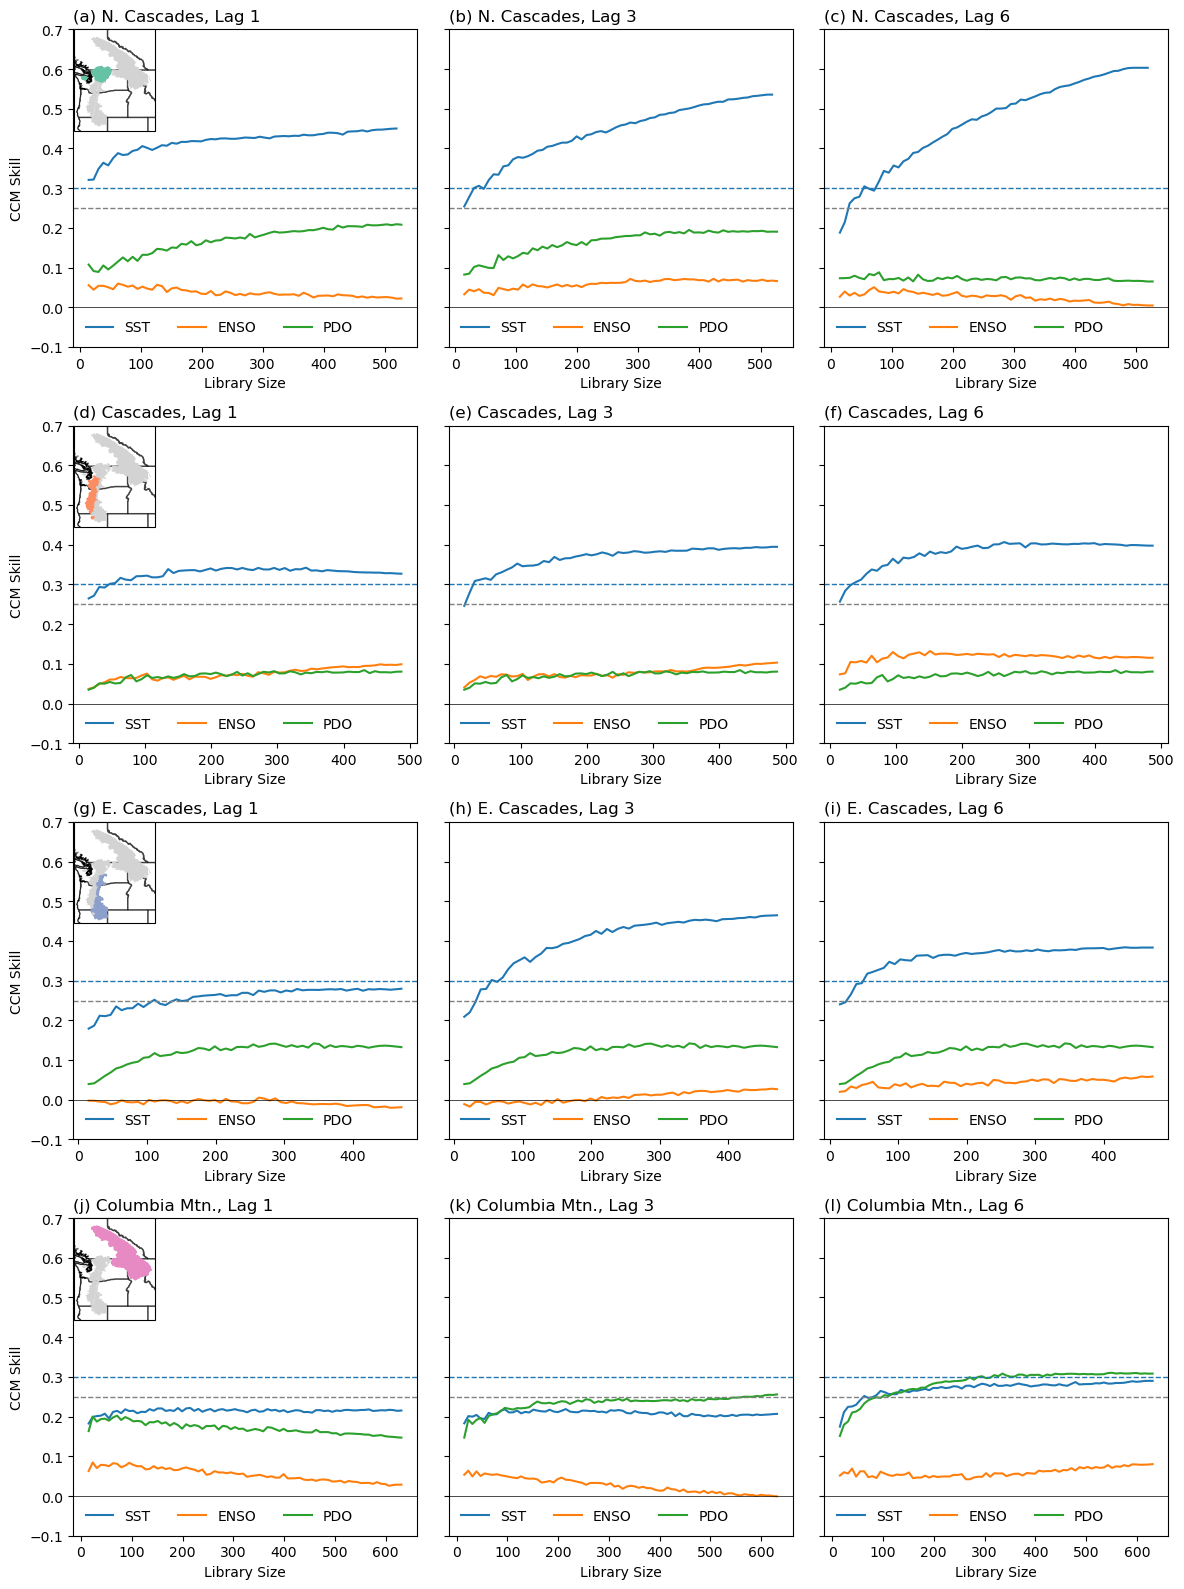

In [75]:
fig = plt.figure(figsize=(12,16))
gs = fig.add_gridspec(4,3)

ax3 = fig.add_subplot(gs[0,2])
ax1 = fig.add_subplot(gs[0,0], sharey=ax3)
ax2 = fig.add_subplot(gs[0,1], sharey=ax3)

ax4 = fig.add_subplot(gs[1,0], sharey=ax3)
ax5 = fig.add_subplot(gs[1,1], sharey=ax3)
ax6 = fig.add_subplot(gs[1,2], sharey=ax3)

ax7 = fig.add_subplot(gs[2,0], sharey=ax3)
ax8 = fig.add_subplot(gs[2,1], sharey=ax3)
ax9 = fig.add_subplot(gs[2,2], sharey=ax3)

ax10 = fig.add_subplot(gs[3,0], sharey=ax3)
ax11 = fig.add_subplot(gs[3,1], sharey=ax3)
ax12 = fig.add_subplot(gs[3,2], sharey=ax3)


ccm_NC_sst_lag1.libMeans.plot(ax=ax1, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_NC_enso_lag1.libMeans.plot(ax=ax1, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_NC_pdo_lag1.libMeans.plot(ax=ax1, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_NC_sst_lag3.libMeans.plot(ax=ax2, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_NC_enso_lag3.libMeans.plot(ax=ax2, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_NC_pdo_lag3.libMeans.plot(ax=ax2, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_NC_sst_lag6.libMeans.plot(ax=ax3, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_NC_enso_lag6.libMeans.plot(ax=ax3, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_NC_pdo_lag6.libMeans.plot(ax=ax3, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_Ca_sst_lag1.libMeans.plot(ax=ax4, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_Ca_enso_lag1.libMeans.plot(ax=ax4, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_Ca_pdo_lag1.libMeans.plot(ax=ax4, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_Ca_sst_lag3.libMeans.plot(ax=ax5, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_Ca_enso_lag3.libMeans.plot(ax=ax5, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_Ca_pdo_lag3.libMeans.plot(ax=ax5, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_Ca_sst_lag6.libMeans.plot(ax=ax6, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_Ca_enso_lag6.libMeans.plot(ax=ax6, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_Ca_pdo_lag6.libMeans.plot(ax=ax6, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_EC_sst_lag1.libMeans.plot(ax=ax7, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_EC_enso_lag1.libMeans.plot(ax=ax7, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_EC_pdo_lag1.libMeans.plot(ax=ax7, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_EC_sst_lag3.libMeans.plot(ax=ax8, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_EC_enso_lag3.libMeans.plot(ax=ax8, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_EC_pdo_lag3.libMeans.plot(ax=ax8, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_EC_sst_lag6.libMeans.plot(ax=ax9, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_EC_enso_lag6.libMeans.plot(ax=ax9, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_EC_pdo_lag6.libMeans.plot(ax=ax9, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_CM_sst_lag1.libMeans.plot(ax=ax10, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_CM_enso_lag1.libMeans.plot(ax=ax10, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_CM_pdo_lag1.libMeans.plot(ax=ax10, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_CM_sst_lag3.libMeans.plot(ax=ax11, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_CM_enso_lag3.libMeans.plot(ax=ax11, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_CM_pdo_lag3.libMeans.plot(ax=ax11, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ccm_CM_sst_lag6.libMeans.plot(ax=ax12, x='LibSize', y='swe_level2:sst', label = 'SST')
ccm_CM_enso_lag6.libMeans.plot(ax=ax12, x='LibSize', y='swe_level2:ANOM', label = 'ENSO')
ccm_CM_pdo_lag6.libMeans.plot(ax=ax12, x='LibSize', y='swe_level2:pdo', label = 'PDO')

ax1.set_xlabel('Library Size')
ax2.set_xlabel('Library Size')
ax3.set_xlabel('Library Size')
ax4.set_xlabel('Library Size')
ax5.set_xlabel('Library Size')
ax6.set_xlabel('Library Size')
ax7.set_xlabel('Library Size')
ax8.set_xlabel('Library Size')
ax9.set_xlabel('Library Size')
ax10.set_xlabel('Library Size')
ax11.set_xlabel('Library Size')
ax12.set_xlabel('Library Size')

ax1.set_ylabel('CCM Skill')
ax4.set_ylabel('CCM Skill')
ax7.set_ylabel('CCM Skill')
ax10.set_ylabel('CCM Skill')

ax1.set_title('({}) {}, Lag {}'.format('a', 'N. Cascades', 1), loc='left')
ax2.set_title('({}) {}, Lag {}'.format('b', 'N. Cascades', 3), loc='left')
ax3.set_title('({}) {}, Lag {}'.format('c', 'N. Cascades', 6), loc='left')

ax4.set_title('({}) {}, Lag {}'.format('d', 'Cascades', 1), loc='left')
ax5.set_title('({}) {}, Lag {}'.format('e', 'Cascades', 3), loc='left')
ax6.set_title('({}) {}, Lag {}'.format('f', 'Cascades', 6), loc='left')

ax7.set_title('({}) {}, Lag {}'.format('g', 'E. Cascades', 1), loc='left')
ax8.set_title('({}) {}, Lag {}'.format('h', 'E. Cascades', 3), loc='left')
ax9.set_title('({}) {}, Lag {}'.format('i', 'E. Cascades', 6), loc='left')

ax10.set_title('({}) {}, Lag {}'.format('j', 'Columbia Mtn.', 1), loc='left')
ax11.set_title('({}) {}, Lag {}'.format('k', 'Columbia Mtn.', 3), loc='left')
ax12.set_title('({}) {}, Lag {}'.format('l', 'Columbia Mtn.', 6), loc='left')

ax1.set_ylim([-0.1,0.7])
ax1.legend(ncols=3, loc='lower left', frameon=False)
ax2.legend(ncols=3, loc='lower left', frameon=False)
ax3.legend(ncols=3, loc='lower left', frameon=False)
ax4.legend(ncols=3, loc='lower left', frameon=False)
ax5.legend(ncols=3, loc='lower left', frameon=False)
ax6.legend(ncols=3, loc='lower left', frameon=False)
ax7.legend(ncols=3, loc='lower left', frameon=False)
ax8.legend(ncols=3, loc='lower left', frameon=False)
ax9.legend(ncols=3, loc='lower left', frameon=False)
ax10.legend(ncols=3, loc='lower left', frameon=False)
ax11.legend(ncols=3, loc='lower left', frameon=False)
ax12.legend(ncols=3, loc='lower left', frameon=False)

ax1.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax1.axhline(0.25, color='grey', lw=1, ls='--')
ax2.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax2.axhline(0.25, color='grey', lw=1, ls='--')
ax3.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax3.axhline(0.25, color='grey', lw=1, ls='--')
ax4.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax4.axhline(0.25, color='grey', lw=1, ls='--')
ax5.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax5.axhline(0.25, color='grey', lw=1, ls='--')
ax6.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax6.axhline(0.25, color='grey', lw=1, ls='--')
ax7.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax7.axhline(0.25, color='grey', lw=1, ls='--')
ax8.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax8.axhline(0.25, color='grey', lw=1, ls='--')
ax9.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax9.axhline(0.25, color='grey', lw=1, ls='--')
ax10.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax10.axhline(0.25, color='grey', lw=1, ls='--')
ax11.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax11.axhline(0.25, color='grey', lw=1, ls='--')
ax12.axhline(0.3, color='tab:blue', lw=1, ls='--')
ax12.axhline(0.25, color='grey', lw=1, ls='--')

ax1.axhline(0, color='k', lw=0.5)
ax2.axhline(0, color='k', lw=0.5)
ax3.axhline(0, color='k', lw=0.5)
ax4.axhline(0, color='k', lw=0.5)
ax5.axhline(0, color='k', lw=0.5)
ax6.axhline(0, color='k', lw=0.5)
ax7.axhline(0, color='k', lw=0.5)
ax8.axhline(0, color='k', lw=0.5)
ax9.axhline(0, color='k', lw=0.5)
ax10.axhline(0, color='k', lw=0.5)
ax11.axhline(0, color='k', lw=0.5)
ax12.axhline(0, color='k', lw=0.5)

c_Set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

for i, a in enumerate([ax1, ax4, ax7, ax10]):
    coast_ecos = ['North Cascades', 'Cascades', 'Eastern Cascades Slopes and Foothills','Columbia Mountains/Northern Rockies']
    inset_ax = inset_axes(a, width="24%", height="32%", loc='upper left',
                              axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                              axes_kwargs=dict(
                                  map_projection=ccrs.PlateCarree()), borderpad=0)
    plotting = coast_ecos.pop(i)
    # [-130, -113, 40, 55], crs=ccrs.PlateCarree()
    inset_ax.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
    inset_ax.coastlines(resolution='50m', color='black', linewidth=0.5)
    inset_ax.add_feature(cfeature.STATES, alpha=0.5)
    # wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].boundary.plot(ax=inset_ax, color='black', alpha=0.5)
    wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].plot(ax=inset_ax, transform=crs, color='lightgrey', zorder=2)
    inset_ax.add_geometries(wus_eco[wus_eco['NA_L3NAME']==plotting]['geometry'],
                            crs=ccrs.PlateCarree(), color=c_Set2[i])

plt.tight_layout()
plt.savefig(pub_dir_main+'fig3a_3l.eps', bbox_inches='tight', facecolor='w')

In [68]:
def ccm_projections(ccm_obj):
    ccm_obj.RevMap.FindNeighbors()
    ccm_obj.RevMap.Project()
    ccm_obj.RevMap.FormatProjection()

    ccm_re = ccm_obj.RevMap.Projection
    ccm_re['dtime'] = ccm_re['Time'].map(lambda x: datetime.datetime.fromisoformat(x))
    return(ccm_re)


def lagged_regression(df, lag):
    X = df['sst'][0:-lag].to_numpy()
    y = df['swe_level2'][lag:].to_numpy()

    x_train, x_test, y_train, y_test = train_test_split(X,y,random_state=42)
    m, b, rho, p, std_err = stats.linregress(x_train, y_train)
    y_pred = m*X - b
    r2x = r2_score(y, y_pred)
    print(r2x)
    return(y_pred)

In [69]:
swe_re_ccm_l1_Ca = ccm_projections(ccm_Ca_sst_lag1)
swe_re_ccm_l3_Ca = ccm_projections(ccm_Ca_sst_lag3)
swe_re_ccm_l6_Ca = ccm_projections(ccm_Ca_sst_lag6)

In [70]:
df_swe_Ca = CCMsetup(-1, sst)

In [71]:
swe_re_lm_l1_Ca = lagged_regression(df_swe_Ca, 1)
swe_re_lm_l3_Ca = lagged_regression(df_swe_Ca, 3)
swe_re_lm_l6_Ca = lagged_regression(df_swe_Ca, 6)

0.15207987232525533
0.09753185032584932
0.06305721393971475


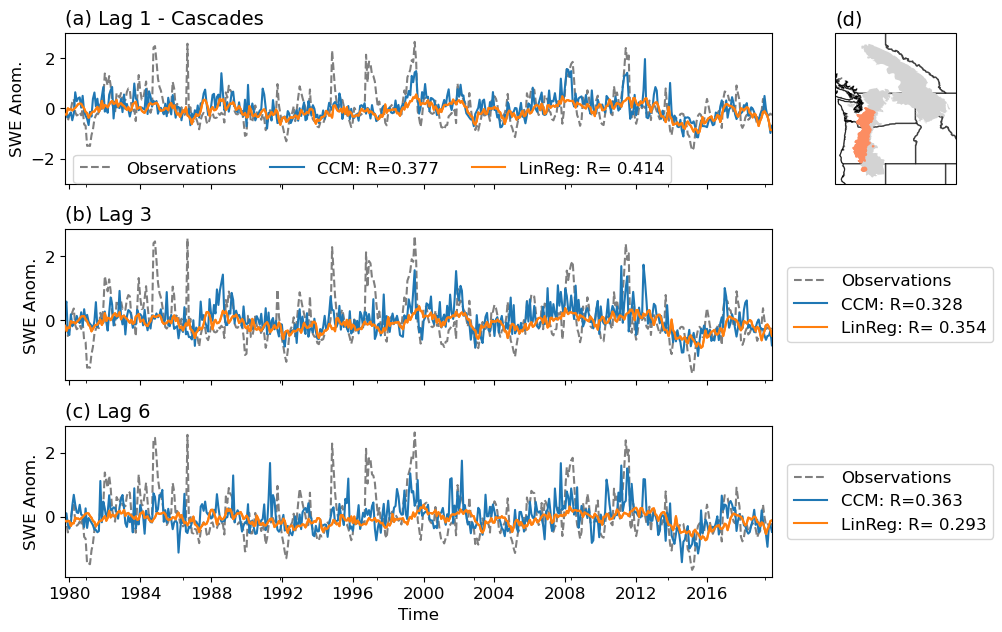

In [72]:
coast_ecos = ['North Cascades', 'Cascades',
              'Eastern Cascades Slopes and Foothills',
              'Columbia Mountains/Northern Rockies']
df_swe_Ca['dtime'] = df_swe_Ca['time'].map(lambda x: datetime.datetime.fromisoformat(x))

# fig, ax = plt.subplots(figsize=(15,5))
fig = plt.figure(layout='tight', figsize=(13,8))
gs = fig.add_gridspec(3,2, width_ratios=[2,1], wspace=-0.1, hspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[2,0], sharex=ax1)

ax_map = fig.add_subplot(gs[0,1],
                         projection=ccrs.PlateCarree(central_longitude=180))
# - Lag 1 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l1_Ca, df_swe_Ca['swe_level2'][1:])
r2, p2 = stats.pearsonr(swe_re_ccm_l1_Ca['Observations'], swe_re_ccm_l1_Ca['Predictions'])

ax1.plot(df_swe_Ca['dtime'][1:], swe_re_lm_l1_Ca, color='tab:orange', zorder=5)
swe_re_ccm_l1_Ca.plot(ax=ax1, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l1_Ca.plot(ax=ax1, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax1.plot(df_swe_Ca['dtime'][1:], swe_re_lm_l1_Ca, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax1.set_title('(a) Lag 1 - Cascades', loc='left', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SWE Anom.', fontsize=12)
ax1.legend(ncols=3, bbox_to_anchor=(0, 0.1), loc='center left', fontsize=12)
ax1.set_xlim([swe_re_ccm_l1_Ca.dtime[0], swe_re_ccm_l1_Ca.dtime.iloc[-1]])

# - Lag 3 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l3_Ca, df_swe_Ca['swe_level2'][3:])
r2, p2 = stats.pearsonr(swe_re_ccm_l3_Ca['Observations'], swe_re_ccm_l3_Ca['Predictions'])

ax2.plot(df_swe_Ca['dtime'][3:], swe_re_lm_l3_Ca, color='tab:orange', zorder=5)
swe_re_ccm_l3_Ca.plot(ax=ax2, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l3_Ca.plot(ax=ax2, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax2.plot(df_swe_Ca['dtime'][3:], swe_re_lm_l3_Ca, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax2.set_title('(b) Lag 3', loc='left', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('SWE Anom.', fontsize=12)
ax2.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax2.set_xlim([swe_re_ccm_l6_Ca.dtime[0], swe_re_ccm_l6_Ca.dtime.iloc[-1]])

# - Lag 6 ---------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l6_Ca, df_swe_Ca['swe_level2'][6:])
r2, p2 = stats.pearsonr(swe_re_ccm_l6_Ca['Observations'], swe_re_ccm_l6_Ca['Predictions'])

ax3.plot(df_swe_Ca['dtime'][6:], swe_re_lm_l6_Ca, color='tab:orange', zorder=5)
swe_re_ccm_l6_Ca.plot(ax=ax3, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l6_Ca.plot(ax=ax3, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax3.plot(df_swe_Ca['dtime'][6:], swe_re_lm_l6_Ca, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax3.set_title('(c) Lag 6', loc='left', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('SWE Anom.', fontsize=12)
ax3.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax3.set_xlim([swe_re_ccm_l6_Ca.dtime[0], swe_re_ccm_l6_Ca.dtime.iloc[-1]])
plt.setp(ax3.get_xticklabels(), horizontalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

c_Set2 = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']

wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].plot(ax=ax_map,
                                                    transform=crs,
                                                    color='lightgrey', zorder=2)
ax_map.add_geometries(wus_eco[wus_eco['NA_L3NAME']=="Cascades"]['geometry'],
                            crs=ccrs.PlateCarree(), color=c_Set2[1], zorder=3)
ax_map.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
ax_map.coastlines(resolution='50m', color='black', linewidth=0.5)
ax_map.add_feature(cfeature.STATES, alpha=0.5)
ax_map.set_title('(d)', loc='left', fontsize=14)

ax1.set_ylim([-3,3])

# plt.savefig(pub_dir_main+'fig4a_4d.eps',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)

plt.show()

In [73]:
swe_re_ccm_l1_NC = ccm_projections(ccm_NC_sst_lag1)
swe_re_ccm_l3_NC = ccm_projections(ccm_NC_sst_lag3)
swe_re_ccm_l6_NC = ccm_projections(ccm_NC_sst_lag6)

df_swe_NC = CCMsetup(8, sst)

In [74]:
swe_re_lm_l1_NC = lagged_regression(df_swe_NC, 1)
swe_re_lm_l3_NC = lagged_regression(df_swe_NC, 3)
swe_re_lm_l6_NC = lagged_regression(df_swe_NC, 6)

0.11923815406957161
0.07519227529230554
0.0479963444048922


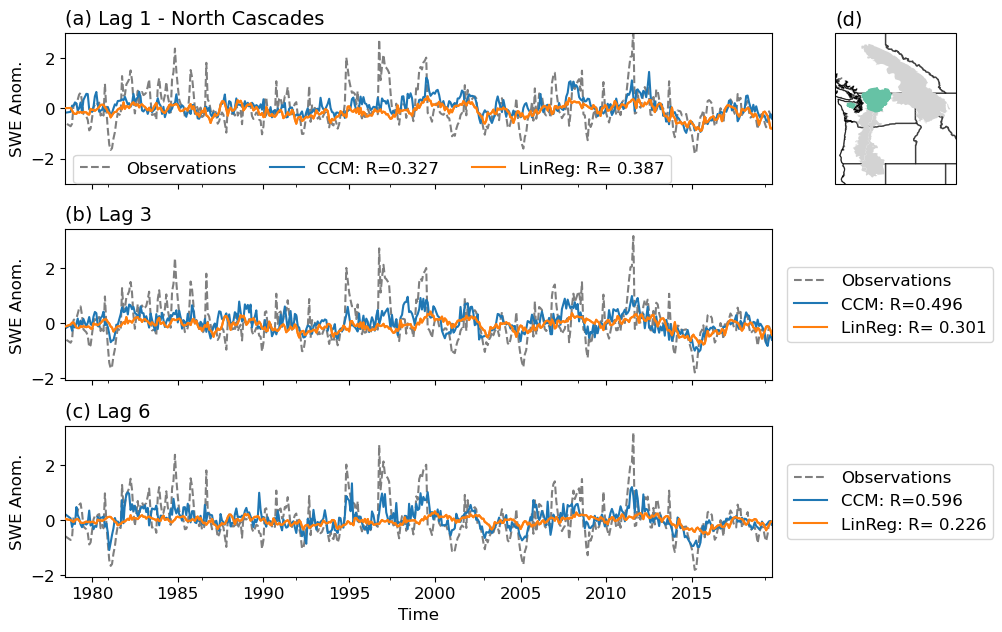

In [75]:
coast_ecos = ['Cascades', 'North Cascades',
              'Eastern Cascades Slopes and Foothills',
              'Columbia Mountains/Northern Rockies']
df_swe_NC['dtime'] = df_swe_NC['time'].map(lambda x: datetime.datetime.fromisoformat(x))

# fig, ax = plt.subplots(figsize=(15,5))
fig = plt.figure(layout='tight', figsize=(13,8))
gs = fig.add_gridspec(3,2, width_ratios=[2,1], wspace=-0.1, hspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[2,0], sharex=ax1)

ax_map = fig.add_subplot(gs[0,1],
                         projection=ccrs.PlateCarree(central_longitude=180))
# - Lag 1 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l1_NC, df_swe_NC['swe_level2'][1:])
r2, p2 = stats.pearsonr(swe_re_ccm_l1_NC['Observations'], swe_re_ccm_l1_NC['Predictions'])

ax1.plot(df_swe_NC['dtime'][1:], swe_re_lm_l1_NC, color='tab:orange', zorder=5)
swe_re_ccm_l1_NC.plot(ax=ax1, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l1_NC.plot(ax=ax1, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax1.plot(df_swe_NC['dtime'][1:], swe_re_lm_l1_NC, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax1.set_title('(a) Lag 1 - North Cascades', loc='left', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SWE Anom.', fontsize=12)
ax1.legend(ncols=3, bbox_to_anchor=(0, 0.1), loc='center left', fontsize=12)
ax1.set_xlim([swe_re_ccm_l1_NC.dtime[0], swe_re_ccm_l1_NC.dtime.iloc[-1]])

# - Lag 3 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l3_NC, df_swe_NC['swe_level2'][3:])
r2, p2 = stats.pearsonr(swe_re_ccm_l3_NC['Observations'], swe_re_ccm_l3_NC['Predictions'])

ax2.plot(df_swe_NC['dtime'][3:], swe_re_lm_l3_NC, color='tab:orange', zorder=5)
swe_re_ccm_l3_NC.plot(ax=ax2, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l3_NC.plot(ax=ax2, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax2.plot(df_swe_NC['dtime'][3:], swe_re_lm_l3_NC, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax2.set_title('(b) Lag 3', loc='left', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('SWE Anom.', fontsize=12)
ax2.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax2.set_xlim([swe_re_ccm_l6_NC.dtime[0], swe_re_ccm_l6_NC.dtime.iloc[-1]])

# - Lag 6 ---------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l6_NC, df_swe_NC['swe_level2'][6:])
r2, p2 = stats.pearsonr(swe_re_ccm_l6_NC['Observations'], swe_re_ccm_l6_NC['Predictions'])

ax3.plot(df_swe_NC['dtime'][6:], swe_re_lm_l6_NC, color='tab:orange', zorder=5)
swe_re_ccm_l6_NC.plot(ax=ax3, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l6_NC.plot(ax=ax3, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax3.plot(df_swe_NC['dtime'][6:], swe_re_lm_l6_NC, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax3.set_title('(c) Lag 6', loc='left', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('SWE Anom.', fontsize=12)
ax3.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax3.set_xlim([swe_re_ccm_l6_NC.dtime[0], swe_re_ccm_l6_NC.dtime.iloc[-1]])
plt.setp(ax3.get_xticklabels(), horizontalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].plot(ax=ax_map,
                                                    transform=crs,
                                                    color='lightgrey', zorder=2)
ax_map.add_geometries(wus_eco[wus_eco['NA_L3NAME']=="North Cascades"]['geometry'],
                            crs=ccrs.PlateCarree(), color=c_Set2[0], zorder=3)
ax_map.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
ax_map.coastlines(resolution='50m', color='black', linewidth=0.5)
ax_map.add_feature(cfeature.STATES, alpha=0.5)

ax_map.set_title('(d)', loc='left', fontsize=14)
ax1.set_ylim([-3,3])

# plt.savefig(pub_dir_main+'fig5a_5d.eps',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)

plt.show()

In [76]:
swe_re_ccm_l1_CM = ccm_projections(ccm_CM_sst_lag1)
swe_re_ccm_l3_CM = ccm_projections(ccm_CM_sst_lag3)
swe_re_ccm_l6_CM = ccm_projections(ccm_CM_sst_lag6)

df_swe_CM = CCMsetup(10, sst)

In [77]:
swe_re_lm_l1_CM = lagged_regression(df_swe_CM, 1)
swe_re_lm_l3_CM = lagged_regression(df_swe_CM, 3)
swe_re_lm_l6_CM = lagged_regression(df_swe_CM, 6)

0.07334555846753321
0.03420734872150266
0.020997124797725752


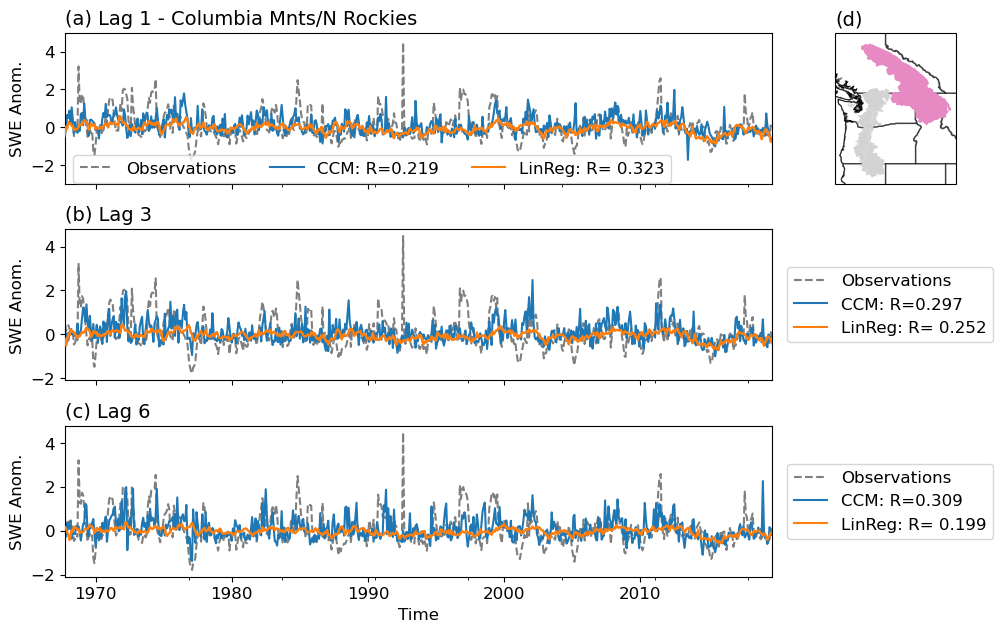

In [78]:
 coast_ecos = ['Cascades', 'North Cascades',
               'Eastern Cascades Slopes and Foothills',
               'Columbia Mountains/Northern Rockies']
df_swe_CM['dtime'] = df_swe_CM['time'].map(lambda x: datetime.datetime.fromisoformat(x))

# fig, ax = plt.subplots(figsize=(15,5))
fig = plt.figure(layout='tight', figsize=(13,8))
gs = fig.add_gridspec(3,2, width_ratios=[2,1], wspace=-0.1, hspace=0.3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
ax3 = fig.add_subplot(gs[2,0], sharex=ax1)

ax_map = fig.add_subplot(gs[0,1],
                         projection=ccrs.PlateCarree(central_longitude=180))
# - Lag 1 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l1_CM, df_swe_CM['swe_level2'][1:])
r2, p2 = stats.pearsonr(swe_re_ccm_l1_CM['Observations'], swe_re_ccm_l1_CM['Predictions'])

ax1.plot(df_swe_CM['dtime'][1:], swe_re_lm_l1_CM, color='tab:orange', zorder=5)
swe_re_ccm_l1_CM.plot(ax=ax1, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l1_CM.plot(ax=ax1, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax1.plot(df_swe_CM['dtime'][1:], swe_re_lm_l1_CM, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax1.set_title('(a) Lag 1 - Columbia Mnts/N Rockies', loc='left', fontsize=14)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('SWE Anom.', fontsize=12)
ax1.legend(ncols=3, bbox_to_anchor=(0, 0.1), loc='center left', fontsize=12)
ax1.set_xlim([swe_re_ccm_l1_CM.dtime[0], swe_re_ccm_l1_CM.dtime.iloc[-1]])

# - Lag 3 ------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l3_CM, df_swe_CM['swe_level2'][3:])
r2, p2 = stats.pearsonr(swe_re_ccm_l3_CM['Observations'], swe_re_ccm_l3_CM['Predictions'])

ax2.plot(df_swe_CM['dtime'][3:], swe_re_lm_l3_CM, color='tab:orange', zorder=5)
swe_re_ccm_l3_CM.plot(ax=ax2, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l3_CM.plot(ax=ax2, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax2.plot(df_swe_CM['dtime'][3:], swe_re_lm_l3_CM, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax2.set_title('(b) Lag 3', loc='left', fontsize=14)
ax2.set_xlabel('Time', fontsize=12)
ax2.set_ylabel('SWE Anom.', fontsize=12)
ax2.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax2.set_xlim([swe_re_ccm_l6_CM.dtime[0], swe_re_ccm_l6_CM.dtime.iloc[-1]])

# - Lag 6 ---------------------------------------------------------------------------------
r1, p1 = stats.pearsonr(swe_re_lm_l6_CM, df_swe_CM['swe_level2'][6:])
r2, p2 = stats.pearsonr(swe_re_ccm_l6_CM['Observations'], swe_re_ccm_l6_CM['Predictions'])

ax3.plot(df_swe_CM['dtime'][6:], swe_re_lm_l6_CM, color='tab:orange', zorder=5)
swe_re_ccm_l6_CM.plot(ax=ax3, x='dtime', y='Observations', ls='--', color='k', alpha=0.5)
swe_re_ccm_l6_CM.plot(ax=ax3, x='dtime', y='Predictions', label='CCM: R={:.3f}'.format(r2), rot=0)
ax3.plot(df_swe_CM['dtime'][6:], swe_re_lm_l6_CM, color='tab:orange', label='LinReg: R= {:.3f}'.format(r1))

ax3.set_title('(c) Lag 6', loc='left', fontsize=14)
ax3.set_xlabel('Time', fontsize=12)
ax3.set_ylabel('SWE Anom.', fontsize=12)
ax3.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=12)
ax3.set_xlim([swe_re_ccm_l6_CM.dtime[0], swe_re_ccm_l6_CM.dtime.iloc[-1]])
plt.setp(ax3.get_xticklabels(), horizontalalignment='center')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)

wus_eco[wus_eco['NA_L3NAME'].isin(coast_ecos)].plot(ax=ax_map,
                                                    transform=crs,
                                                    color='lightgrey', zorder=2)
ax_map.add_geometries(wus_eco[wus_eco['NA_L3NAME']=="Columbia Mountains/Northern Rockies"]['geometry'],
                            crs=ccrs.PlateCarree(), color=c_Set2[3], zorder=3)
ax_map.set_extent([-125, -113, 40, 55], crs=ccrs.PlateCarree())
ax_map.coastlines(resolution='50m', color='black', linewidth=0.5)
ax_map.add_feature(cfeature.STATES, alpha=0.5)

ax_map.set_title('(d)', loc='left', fontsize=14)
ax1.set_ylim([-3,5])

# plt.savefig(pub_dir_main+'fig6a_6d.eps',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=300)

plt.show()

In [109]:
low_high_years_Ca = [1981, 1992, 2001, 2005, 2015, 1999, 2008, 1997, 1982, 1989]
low_high_years_NC = [1997, 1999, 2011, 2012, 1981, 2001, 2005, 2015]
low_high_years_CM = [1977, 2001, 2005, 2015, 1968, 1999, 1974, 1972]
# low_high_years_EC = [1981, 1992, 2001, 2005, 2015, 1999, 2008, 1997, 1982, 1989]

In [80]:
def getWaterYear(y, m):
    if (m == 10) | (m == 11) | (m==12):
        y = y+1
    else:
        y = y
    return(y)

def compSWEAnom(SWE, CCM, LM, hl_years):
    CCM['year'] = CCM['dtime'].dt.year
    CCM['month'] = CCM['dtime'].dt.month

    CCM['wyear'] = CCM.apply(lambda x: getWaterYear(x['year'], x['month']), axis=1)
    CCM_anoms = CCM[CCM['month'].isin([12,1,2,3])]
    CCM_hl_anoms = CCM_anoms[CCM_anoms['wyear'].isin(hl_years)]

    SWE['SWE_lm_pred'] = np.nan
    SWE['SWE_lm_pred'][6:] = LM

    SWE['year'] = SWE['dtime'].dt.year
    SWE['month'] = SWE['dtime'].dt.month

    SWE['wyear'] = SWE.apply(lambda x: getWaterYear(x['year'], x['month']), axis=1)
    LM_anoms = SWE[SWE['month'].isin([12,1,2,3])]
    LM_hl_anoms = LM_anoms[LM_anoms['wyear'].isin(hl_years)]
    return(CCM_hl_anoms, LM_hl_anoms)

In [127]:
CCM_anoms_Ca, LM_anoms_Ca = compSWEAnom(df_swe_Ca, swe_re_ccm_l6_Ca, swe_re_lm_l6_Ca, low_high_years_Ca)
CCM_anoms_NC, LM_anoms_NC = compSWEAnom(df_swe_NC, swe_re_ccm_l6_NC, swe_re_lm_l6_NC, low_high_years_NC)
CCM_anoms_CM, LM_anoms_CM = compSWEAnom(df_swe_CM, swe_re_ccm_l6_CM, swe_re_lm_l6_CM, low_high_years_CM)

In [219]:
test = CCM_anoms_NC[['Observations', 'Predictions', 'wyear']].groupby(by='wyear').mean()
mae_ccm = test.apply(lambda x: mean_abs_error(x['Observations'], x['Predictions']), axis=1)

In [220]:
test2 = LM_anoms_NC[['swe_level2','SWE_lm_pred', 'wyear']].groupby(by='wyear').mean()
mae_llr = test2.apply(lambda x: mean_abs_error(x['swe_level2'], x['SWE_lm_pred']), axis=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


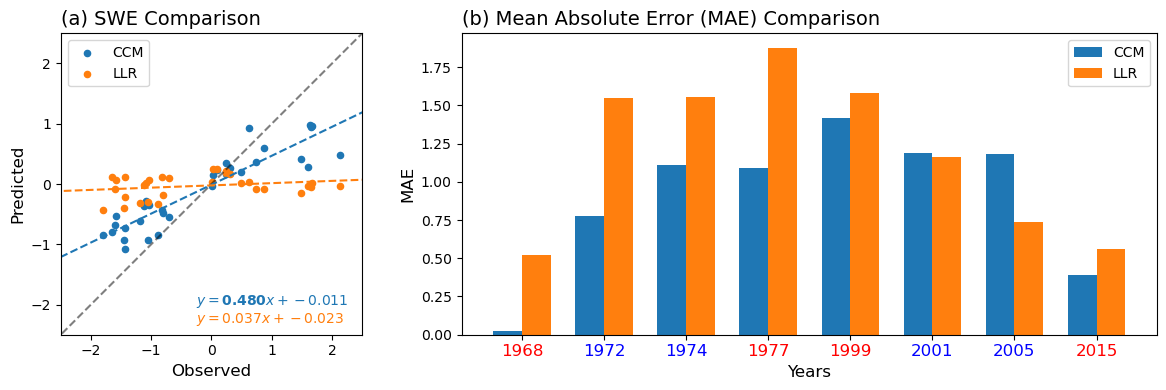

In [265]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,2, width_ratios = [1,2], height_ratios=[1])
ax1 = fig.add_subplot(gs[0])
ax1.set_aspect('equal', adjustable='box')

ax1.plot(np.arange(-3,3.1,0.1),np.arange(-3,3.1,0.1), ls='--', color='k', alpha=0.5)
CCM_anoms_NC.plot(ax=ax1, kind='scatter', x='Observations', y='Predictions', label='CCM')
LM_anoms_NC.plot(ax=ax1, kind='scatter', x='swe_level2', y='SWE_lm_pred', label='LLR', color='tab:orange')

ax1.set_title('(a) SWE Comparison', fontsize=14, loc='left')
ax1.set_xlabel('Observed', fontsize=12)
ax1.set_ylabel('Predicted', fontsize=12)
ax1.axis([-2.5,2.5,-2.5,2.5])

# compute the slope through lin.reg. for CCM and LM
mc, bc, rhoc, pc, std_errc = stats.linregress(CCM_anoms_NC['Observations'], CCM_anoms_NC['Predictions'])
# print(mc)
ml, bl, rhol, pl, std_errl = stats.linregress(LM_anoms_NC['swe_level2'], LM_anoms_NC['SWE_lm_pred'])
# print(ml)
xs = np.arange(-3,3.1,1)
ys_c = mc*xs+bc
ys_l = ml*xs+bl
ax1.plot(xs, ys_c, '--')
ax1.plot(xs, ys_l, '--')
ax1.text(-0.25,-2,r'$y = \mathbf{{{:.3f}}}x+{:.3f}$'.format(mc, bc), color='tab:blue')
ax1.text(-0.25,-2.3,r'$y = {:.3f}x+{:.3f}$'.format(ml, bl), color='tab:orange')

ax2 = fig.add_subplot(gs[1])
width=0.35
x = np.arange(len(mae_ccm))
ax2.bar(height = mae_ccm, x=x-width/2, width=width, label='CCM')
ax2.bar(height = mae_llr, x=x+width/2, width=width, label='LLR')

label_col = ['red','blue','blue','red','red','blue','blue','red']

ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels(mae_ccm.index, size=12)
[t.set_color(i) for (i,t) in zip(label_col, ax2.xaxis.get_ticklabels())]
ax2.set_xlabel('Years', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('(b) Mean Absolute Error (MAE) Comparison', fontsize=14, loc='left')
plt.tight_layout()
plt.savefig(pub_dir_main+'fig7a_7b.eps',
            bbox_inches='tight',
            facecolor='w',
            dpi=300)
plt.show()

In [222]:
print(pc<0.05, pl)

True 0.1726633162267032


In [99]:
# Cascades comparison before/after 1999
ccm_l1_pre1999 = swe_re_ccm_l1_Ca[swe_re_ccm_l1_Ca['dtime'].dt.year<1999]
ccm_l1_post1999 = swe_re_ccm_l1_Ca[swe_re_ccm_l1_Ca['dtime'].dt.year>1999]

r_pre, p_val_pre = stats.pearsonr(ccm_l1_pre1999['Observations'], ccm_l1_pre1999['Predictions'])
r_post, p_val_post = stats.pearsonr(ccm_l1_post1999['Observations'], ccm_l1_post1999['Predictions'])

print("Lag 1")
print("Pre-1999 : {:.3f}".format(r_pre))
print("Post-1999: {:.3f}".format(r_post))

Lag 1
Pre-1999 : 0.157
Post-1999: 0.472


In [100]:
# Cascades comparison before/after 1999
ccm_l3_pre1999 = swe_re_ccm_l3_Ca[swe_re_ccm_l3_Ca['dtime'].dt.year<1999]
ccm_l3_post1999 = swe_re_ccm_l3_Ca[swe_re_ccm_l3_Ca['dtime'].dt.year>1999]

r_pre, p_val_pre = stats.pearsonr(ccm_l3_pre1999['Observations'], ccm_l3_pre1999['Predictions'])
r_post, p_val_post = stats.pearsonr(ccm_l3_post1999['Observations'], ccm_l3_post1999['Predictions'])

print("Lag 3")
print("Pre-1999 : {:.3f}".format(r_pre))
print("Post-1999: {:.3f}".format(r_post))

Lag 3
Pre-1999 : 0.186
Post-1999: 0.402


In [101]:
# Cascades comparison before/after 1999
ccm_l6_pre1999 = swe_re_ccm_l6_Ca[swe_re_ccm_l6_Ca['dtime'].dt.year<1999]
ccm_l6_post1999 = swe_re_ccm_l6_Ca[swe_re_ccm_l6_Ca['dtime'].dt.year>1999]

r_pre, p_val_pre = stats.pearsonr(ccm_l6_pre1999['Observations'], ccm_l6_pre1999['Predictions'])
r_post, p_val_post = stats.pearsonr(ccm_l6_post1999['Observations'], ccm_l6_post1999['Predictions'])

print("Lag 6")
print("Pre-1999 : {:.3f}".format(r_pre))
print("Post-1999: {:.3f}".format(r_post))

Lag 6
Pre-1999 : 0.251
Post-1999: 0.432


In [90]:
nc_wy1982_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1981-10-01','1982-09-01'))
nc_wy1985_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1984-10-01','1985-09-01'))
nc_wy1989_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1988-10-01','1989-09-01'))
nc_wy1997_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1996-10-01','1997-09-01'))
nc_wy1999_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01'))
nc_wy2006_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2005-10-01','2006-09-01'))
nc_wy2008_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2007-10-01','2008-09-01'))
nc_wy2011_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2010-10-01','2011-09-01'))

h_mean_c = np.mean([nc_wy1982_h, nc_wy1985_h, nc_wy1989_h,
                    nc_wy1997_h, nc_wy1999_h, nc_wy2006_h,
                    nc_wy2008_h, nc_wy2011_h], axis=0)
h_std_c = np.std([nc_wy1982_h, nc_wy1985_h, nc_wy1989_h,
                  nc_wy1997_h, nc_wy1999_h, nc_wy2006_h,
                  nc_wy2008_h, nc_wy2011_h], axis=0)

nc_wy1981_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1980-10-01','1981-09-01'))
nc_wy1992_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1991-10-01','1992-09-01'))
nc_wy2001_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2000-10-01','2001-09-01'))
nc_wy2005_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01'))
nc_wy2015_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01'))

l_mean_c = np.mean([nc_wy1981_l, nc_wy1992_l, nc_wy2001_l,
                    nc_wy2005_l, nc_wy2015_l], axis=0)
l_std_c = np.std([nc_wy1981_l, nc_wy1992_l, nc_wy2001_l,
                  nc_wy2005_l, nc_wy2015_l], axis=0)

In [91]:
nc_wy1974_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1973-10-01','1974-09-01'))
nc_wy1975_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1974-10-01','1975-09-01'))
nc_wy1976_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1975-10-01','1976-09-01'))
nc_wy1978_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1977-10-01','1978-09-01'))
nc_wy1999_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01'))

h_mean_nc = np.mean([nc_wy1974_h, nc_wy1975_h, nc_wy1976_h,
                     nc_wy1978_h, nc_wy1999_h], axis=0)
h_std_nc = np.std([nc_wy1974_h, nc_wy1975_h, nc_wy1976_h,
                   nc_wy1978_h, nc_wy1999_h], axis=0)

nc_wy1981_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1980-10-01','1981-09-01'))
nc_wy2001_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2000-10-01','2001-09-01'))
nc_wy2005_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01'))
nc_wy2015_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01'))
l_mean_nc = np.mean([nc_wy1981_l, nc_wy2001_l,
                    nc_wy2005_l, nc_wy2015_l], axis=0)
l_std_nc = np.std([nc_wy1981_l, nc_wy2001_l,
                  nc_wy2005_l, nc_wy2015_l], axis=0)

In [92]:
nc_wy1967_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1966-10-01','1967-09-01'))
nc_wy1968_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1967-10-01','1968-09-01'))
nc_wy1971_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1970-10-01','1971-09-01'))
nc_wy1972_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1971-10-01','1972-09-01'))
nc_wy1974_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1973-10-01','1974-09-01'))
nc_wy1997_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1996-10-01','1997-09-01'))
nc_wy1999_h = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1998-10-01','1999-09-01'))
h_mean_cmnr = np.mean([nc_wy1967_h, nc_wy1968_h, nc_wy1971_h,
                     nc_wy1972_h, nc_wy1974_h, nc_wy1997_h,
                     nc_wy1999_h], axis=0)
h_std_cmnr = np.std([nc_wy1967_h, nc_wy1968_h, nc_wy1971_h,
                     nc_wy1972_h, nc_wy1974_h, nc_wy1997_h,
                     nc_wy1999_h], axis=0)

nc_wy1977_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('1976-10-01','1977-09-01'))
nc_wy2001_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2000-10-01','2001-09-01'))
nc_wy2005_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2004-10-01','2005-09-01'))
nc_wy2015_l = goa_sst.mean(dim=['lat', 'lon']).sst.sel(time=slice('2014-10-01','2015-09-01'))
l_mean_cmnr = np.mean([nc_wy1977_l, nc_wy2001_l,
                    nc_wy2005_l, nc_wy2015_l], axis=0)
l_std_cmnr = np.std([nc_wy1977_l, nc_wy2001_l,
                  nc_wy2005_l, nc_wy2015_l], axis=0)

Text(0, 0.5, 'SST Anom.')

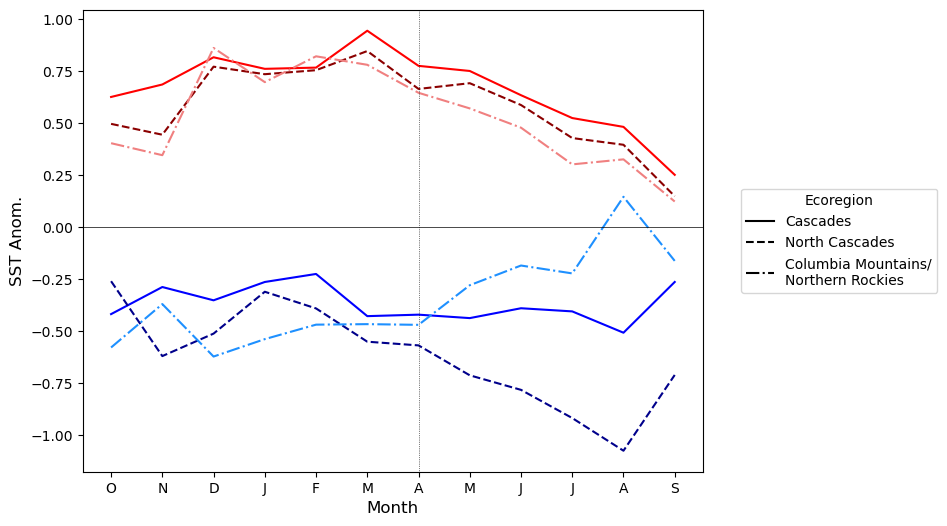

In [93]:
from matplotlib.lines import Line2D

custom_lines = [Line2D([0], [0], ls='-', color='k'),
                Line2D([0], [0], ls='--',color='k'),
                Line2D([0], [0], ls='-.', color='k')]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(np.arange(0,12), h_mean_c, color='blue', label='Cascades, high snow')
ax.plot(np.arange(0,12), l_mean_c, color='red', label='Cascades, low snow')

ax.plot(np.arange(0,12), h_mean_nc, color='darkblue', ls='--', label='North Cascades, high snow')
ax.plot(np.arange(0,12), l_mean_nc, color='darkred', ls='--', label='North Cascades, low snow')

ax.plot(np.arange(0,12), h_mean_cmnr, color='dodgerblue', ls='-.', label='Columbia Mountains/\nNorthern Rockies, high snow')
ax.plot(np.arange(0,12), l_mean_cmnr, color='lightcoral', ls='-.', label='Columbia Mountains/\nNorthern Rockies, low snow')

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], labels=['O', 'N', 'D', 'J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S'])
ax.axvline(6, color='k', ls=':', lw=0.5)
ax.axhline(0, color='k', lw=0.5)
ax.legend(custom_lines, ['Cascades', 'North Cascades', 'Columbia Mountains/\nNorthern Rockies'],
          bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10, title='Ecoregion')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('SST Anom.', fontsize=12)
# plt.savefig(pub_dir_main+'fig8.eps',
#             bbox_inches='tight',
#             facecolor='w',
#             dpi=100)

---
# Supplemental Material Figures

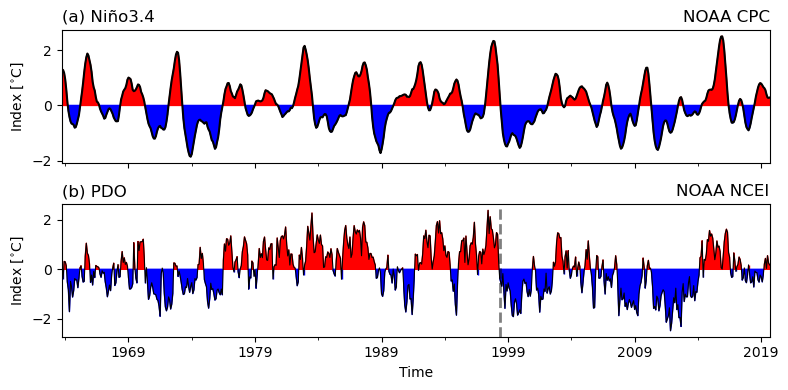

In [252]:
# fig, ax = plt.subplots(figsize=(8,6))
fig = plt.figure(figsize=(8,4))
gs = fig.add_gridspec(2,1)

ax1 = fig.add_subplot(gs[0])
nino34_df = nino34.to_dataframe()
nino34_df.plot(ax=ax1, color='k', legend=False)
ax1.fill_between(nino34_df.index,
                nino34_df.where(nino34_df.ANOM > 0).ANOM,
                0,
                color='r')
ax1.fill_between(nino34_df.index,
                nino34_df.where(nino34_df.ANOM <=0).ANOM,
                0,
                color='b')

ax1.set_title(r'(a) Niño3.4', loc='left')
ax1.set_title('NOAA CPC', loc='right')
ax1.set_xlabel('Time')
ax1.set_ylabel(r'Index [$^{\circ}$C]')

ax2 = fig.add_subplot(gs[1], sharex=ax1)
pdo.pdo.to_dataframe().plot(ax=ax2, y='pdo', color='k', lw=0.8, legend=False)
ax2.fill_between(pdo.pdo.to_dataframe().index,
                pdo.pdo.to_dataframe().where(pdo.pdo.to_dataframe().pdo >0).pdo,
                0,
                color='r')
ax2.fill_between(pdo.pdo.to_dataframe().index,
                pdo.pdo.to_dataframe().where(pdo.pdo.to_dataframe().pdo <=0).pdo,
                0,
                color='b')
ax2.axvline('1998-05-01', color='k', alpha=0.5, ls='--', lw=2)
# ax.axvline('1976-08-01', color='k', alpha=0.5, ls='--', lw=2)
# ax.axvline('1984-03-01', color='k', alpha=0.5, ls='--', lw=2)
# ax.axvline('1981-03-01', color='k', alpha=0.5, ls='--', lw=2)
# ax.axvline('2008-03-01', color='k', alpha=0.5, ls='--', lw=2)


# ax.axvline('1950-10-01', color='m', alpha=0.5, ls='--', lw=2)
# ax.axvline('1997-10-01', color='m', alpha=0.5, ls='--', lw=2)

# ax.axvline('1976-10-01', color='c', alpha=0.5, ls='--', lw=2)
# ax.axvline('2007-10-01', color='c', alpha=0.5, ls='--', lw=2)

ax2.set_title('(b) PDO', loc='left')
ax2.set_title('NOAA NCEI', loc='right')
ax2.set_xlabel('Time')
ax2.set_ylabel(r'Index [$^{\circ}$C]')

plt.tight_layout()
plt.savefig(pub_dir_supp+'fig_s5a_s5b.png',
            bbox_inches='tight',
            facecolor='w',
            dpi=300)

In [253]:
pred = CCM_anoms_Ca[['Observations', 'Predictions', 'wyear']].groupby(by='wyear').mean()
mae_ccm = pred.apply(lambda x: mean_abs_error(x['Observations'], x['Predictions']), axis=1)

pred2 = LM_anoms_Ca[['swe_level2','SWE_lm_pred', 'wyear']].groupby(by='wyear').mean()
mae_llr = pred2.apply(lambda x: mean_abs_error(x['swe_level2'], x['SWE_lm_pred']), axis=1)

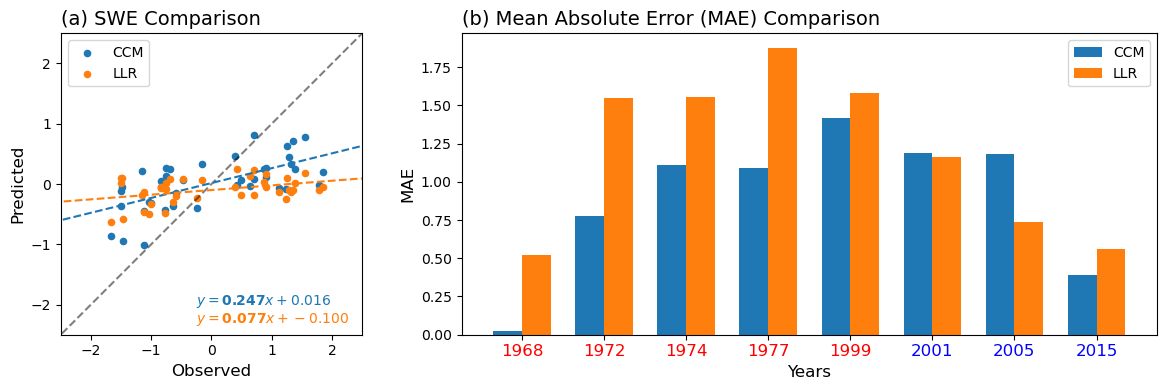

In [267]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,2, width_ratios = [1,2], height_ratios=[1])
ax1 = fig.add_subplot(gs[0])
ax1.set_aspect('equal', adjustable='box')

ax1.plot(np.arange(-3,3.1,0.1),np.arange(-3,3.1,0.1), ls='--', color='k', alpha=0.5)
CCM_anoms_Ca.plot(ax=ax1, kind='scatter', x='Observations', y='Predictions', label='CCM')
LM_anoms_Ca.plot(ax=ax1, kind='scatter', x='swe_level2', y='SWE_lm_pred', label='LLR', color='tab:orange')

# compute the slope through lin.reg. for CCM and LM
mc, bc, rhoc, pc, std_errc = stats.linregress(CCM_anoms_Ca['Observations'], CCM_anoms_Ca['Predictions'])
# print(mc)
ml, bl, rhol, pl, std_errl = stats.linregress(LM_anoms_Ca['swe_level2'], LM_anoms_Ca['SWE_lm_pred'])
# print(ml)

xs = np.arange(-3,3.1,1)
ys_c = mc*xs+bc
ys_l = ml*xs+bl
ax1.plot(xs, ys_c, '--')
ax1.plot(xs, ys_l, '--')
ax1.text(-0.25,-2,r'$y = \mathbf{{{:.3f}}}x+{:.3f}$'.format(mc, bc), color='tab:blue')
ax1.text(-0.25,-2.3,r'$y = \mathbf{{{:.3f}}}x+{:.3f}$'.format(ml, bl), color='tab:orange')

ax1.set_title('(a) SWE Comparison', fontsize=14, loc='left')
ax1.set_xlabel('Observed', fontsize=12)
ax1.set_ylabel('Predicted', fontsize=12)
ax1.axis([-2.5,2.5,-2.5,2.5])

ax2 = fig.add_subplot(gs[1])
width=0.35
x = np.arange(len(mae_ccm))
ax2.bar(height = mae_ccm, x=x-width/2, width=width, label='CCM')
ax2.bar(height = mae_llr, x=x+width/2, width=width, label='LLR')

label_col = ['red','red','red','red', 'red',
             'blue', 'blue', 'blue', 'blue', 'blue']

ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels(mae_ccm.index, size=12)
[t.set_color(i) for (i,t) in zip(label_col,ax2.xaxis.get_ticklabels())]
ax2.set_xlabel('Years', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('(b) Mean Absolute Error (MAE) Comparison', fontsize=14, loc='left')
plt.tight_layout()
plt.savefig(pub_dir_supp+'fig_s6a_s6b.png',
            bbox_inches='tight',
            facecolor='w',
            dpi=300)
plt.show()

In [268]:
print(pc<0.05, pl<0.05)

True True


In [269]:
pred = CCM_anoms_CM[['Observations', 'Predictions', 'wyear']].groupby(by='wyear').mean()
mae_ccm = pred.apply(lambda x: mean_abs_error(x['Observations'], x['Predictions']), axis=1)

pred2 = LM_anoms_CM[['swe_level2','SWE_lm_pred', 'wyear']].groupby(by='wyear').mean()
mae_llr = pred2.apply(lambda x: mean_abs_error(x['swe_level2'], x['SWE_lm_pred']), axis=1)
mae_llr = mae_llr.dropna()

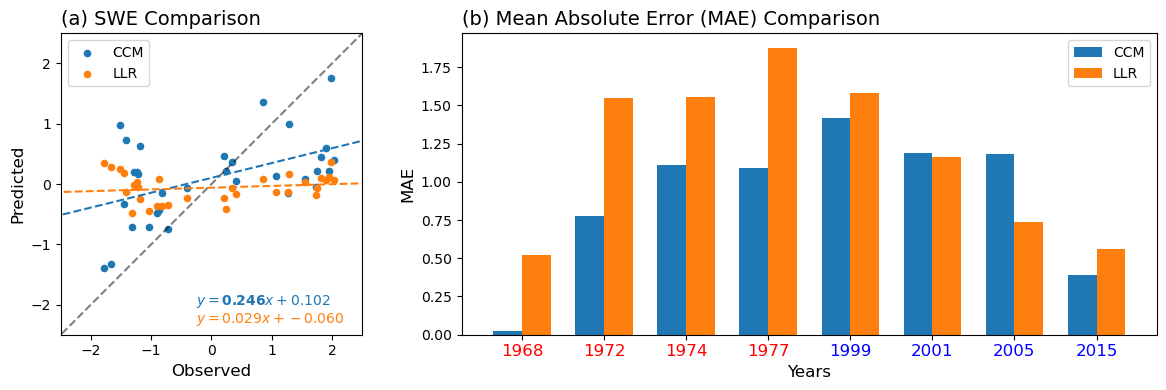

In [270]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(1,2, width_ratios = [1,2], height_ratios=[1])
ax1 = fig.add_subplot(gs[0])
ax1.set_aspect('equal', adjustable='box')

ax1.plot(np.arange(-3,3.1,0.1),np.arange(-3,3.1,0.1), ls='--', color='k', alpha=0.5)
CCM_anoms_CM.plot(ax=ax1, kind='scatter', x='Observations', y='Predictions', label='CCM')
LM_anoms_CM.plot(ax=ax1, kind='scatter', x='swe_level2', y='SWE_lm_pred', label='LLR', color='tab:orange')

# compute the slope through lin.reg. for CCM and LM
mc, bc, rhoc, pc, std_errc = stats.linregress(CCM_anoms_CM['Observations'], CCM_anoms_CM['Predictions'])
# print(mc)
ml, bl, rhol, pl, std_errl = stats.linregress(LM_anoms_CM['swe_level2'], LM_anoms_CM['SWE_lm_pred'])
# print(ml)

xs = np.arange(-3,3.1,1)
ys_c = mc*xs+bc
ys_l = ml*xs+bl
ax1.plot(xs, ys_c, '--')
ax1.plot(xs, ys_l, '--')
ax1.text(-0.25,-2,r'$y = \mathbf{{{:.3f}}}x+{:.3f}$'.format(mc, bc), color='tab:blue')
ax1.text(-0.25,-2.3,r'$y = {:.3f}x+{:.3f}$'.format(ml, bl), color='tab:orange')

ax1.set_title('(a) SWE Comparison', fontsize=14, loc='left')
ax1.set_xlabel('Observed', fontsize=12)
ax1.set_ylabel('Predicted', fontsize=12)
ax1.axis([-2.5,2.5,-2.5,2.5])

ax2 = fig.add_subplot(gs[1])
width=0.35
x = np.arange(len(mae_ccm))
ax2.bar(height = mae_ccm, x=x-width/2, width=width, label='CCM')
ax2.bar(height = mae_llr, x=x+width/2, width=width, label='LLR')

label_col = ['red','red','red','red',
             'blue', 'blue', 'blue', 'blue']

ax2.legend()
ax2.set_xticks(x)
ax2.set_xticklabels(mae_ccm.index, size=12)
[t.set_color(i) for (i,t) in zip(label_col,ax2.xaxis.get_ticklabels())]
ax2.set_xlabel('Years', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.set_title('(b) Mean Absolute Error (MAE) Comparison', fontsize=14, loc='left')
plt.tight_layout()
plt.savefig(pub_dir_supp+'fig_s7a_s7b.png',
            bbox_inches='tight',
            facecolor='w',
            dpi=300)
plt.show()